# <center> **Motorica SkillFactory internship test task 2023-12**

## Импорт библиотек и чтение данных

In [19]:
import numpy as np
import pandas as pd

# import seaborn as sns
from matplotlib import pyplot as plt

import sklearn.linear_model as lm
import sklearn.metrics as m 
import sklearn.model_selection as ms
import sklearn.tree as t 
import sklearn.ensemble as ens 
import sklearn.preprocessing as pp

import warnings
warnings.filterwarnings('ignore')

SEED = 3

In [20]:
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')

y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100)


# Объяснение данных

### Train

`y_train.csv` содержит следующие классы: 
  - `0` - команда "Open";
  - `1` - команда "сгиб мизинца";
  - `2` - команда "сгиб безымянного пальца";
  - `3` - команда "сгиб среднего пальца";
  - `4` - команда "жест пистолет";
  - `5` - команда "сгиб указательного пальца";
  - `6` - команда "сгиб большога пальца";
  - `7` - команда "жест ОК";
  - `8` - команда "жест grab";¶

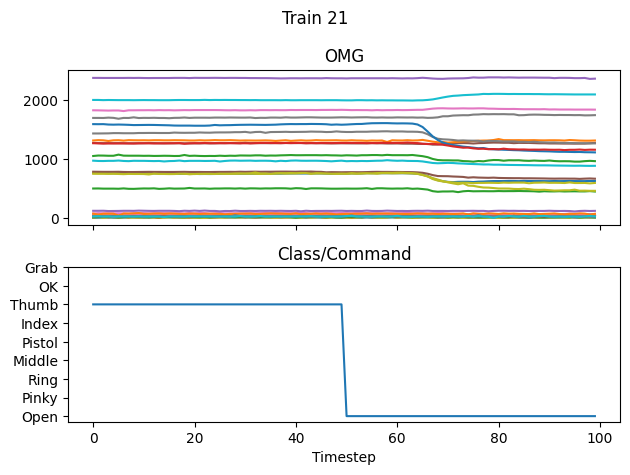

In [25]:
i = 21
fig, axx = plt.subplots(2, 1, sharex=True)
    
axx[0].plot(X_train[i].T)
axx[0].set_title('OMG')

axx[1].plot(y_train[i])
axx[1].set_title('Class/Command')
axx[1].set_xlabel('Timestep')
axx[1].set_yticks(
    np.arange(9),
    ['Open', 'Pinky', 'Ring', 'Middle', 'Pistol', 'Index', 'Thumb', 'OK', 'Grab']
)

plt.suptitle(f'Train {i}')

plt.tight_layout()

### Test

Как видно из визуализации, для теста нет целевой переменной.

Это и есть задача хакатона - предсказать, **какая команда была выполнена пользователем и в какое время**.

# Преобразование данных

In [26]:
def tensor_to_matrix(tensor):
    samples = []

    for X in tensor:
        samples.append(pd.DataFrame(X).T)
        
    return pd.concat(samples, axis=0).reset_index(drop=True)


X_train_2d = tensor_to_matrix(X_train)
X_test_2d = tensor_to_matrix(X_test)

In [27]:
X_train_2d

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,1877.0,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0
1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,1876.0,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0
2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,1878.0,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0
3,1120.0,10.0,1440.0,59.0,32.0,1730.0,143.0,6.0,1066.0,13.0,...,1876.0,68.0,13.0,1165.0,131.0,29.0,1667.0,24.0,726.0,34.0
4,1115.0,16.0,1437.0,51.0,30.0,1724.0,138.0,4.0,1062.0,12.0,...,1872.0,73.0,9.0,1165.0,133.0,29.0,1667.0,32.0,724.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32295,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,1643.0,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0
32296,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,1658.0,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0
32297,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,1661.0,66.0,14.0,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0
32298,1670.0,3.0,1831.0,36.0,28.0,2249.0,40.0,8.0,1368.0,18.0,...,1653.0,76.0,30.0,1207.0,107.0,26.0,1691.0,29.0,391.0,4.0


In [28]:
X_test_2d

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1681.0,4.0,1834.0,33.0,26.0,2254.0,43.0,0.0,1376.0,27.0,...,1635.0,82.0,16.0,1204.0,108.0,25.0,1685.0,27.0,386.0,25.0
1,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,1643.0,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0
2,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,1658.0,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0
3,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,1661.0,66.0,14.0,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0
4,1670.0,3.0,1831.0,36.0,28.0,2249.0,40.0,8.0,1368.0,18.0,...,1653.0,76.0,30.0,1207.0,107.0,26.0,1691.0,29.0,391.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,1887.0,16.0,1856.0,43.0,53.0,2308.0,61.0,16.0,1444.0,24.0,...,1631.0,60.0,11.0,1166.0,120.0,28.0,1675.0,36.0,316.0,29.0
5396,1884.0,17.0,1850.0,27.0,45.0,2304.0,61.0,7.0,1441.0,25.0,...,1641.0,69.0,3.0,1166.0,122.0,28.0,1668.0,29.0,315.0,29.0
5397,1882.0,13.0,1843.0,37.0,51.0,2299.0,60.0,1.0,1437.0,25.0,...,1659.0,75.0,18.0,1167.0,119.0,28.0,1676.0,26.0,313.0,30.0
5398,1886.0,14.0,1835.0,37.0,49.0,2296.0,61.0,5.0,1436.0,25.0,...,1686.0,76.0,9.0,1157.0,122.0,27.0,1673.0,27.0,318.0,32.0


In [29]:
y_train_2d = pd.read_csv('data/y_train.csv')['class']

y_train_2d

0        0
1        0
2        0
3        0
4        0
        ..
32295    4
32296    4
32297    4
32298    4
32299    4
Name: class, Length: 32300, dtype: int64

#### Стандартизация

In [30]:
scaler = pp.StandardScaler()

X_full = pd.concat([X_train_2d, X_test_2d], axis=0)
scaler.fit(X_full)

X_train_2d = scaler.transform(X_train_2d)
X_test_2d = scaler.transform(X_test_2d)

In [31]:
X_train_2d

array([[ 0.15634284, -0.06950633,  0.40318652, ...,  1.80272219,
         1.17222523,  0.51985332],
       [ 0.1629748 , -0.5294926 ,  0.3829491 , ...,  0.3918347 ,
         1.24334451,  0.27257897],
       [ 0.14971088,  1.00379499,  0.38969491, ...,  0.56819564,
         1.22556469,  0.76712766],
       ...,
       [ 1.96686808, -0.06950633,  1.26215239, ..., -1.72449653,
        -0.7717017 ,  0.76712766],
       [ 1.97018407, -1.14280764,  1.25990379, ...,  0.56819564,
        -0.7657751 , -4.92018227],
       [ 1.95692014, -0.37616384,  1.25540658, ..., -0.66633091,
        -0.72428885,  0.51985332]])

In [32]:
X_test_2d

array([[ 2.00665985, -0.98947888,  1.26664959, ...,  0.21547377,
        -0.79540813,  0.27257897],
       [ 2.00002789,  1.00379499,  1.24866078, ..., -0.1372481 ,
        -0.78355492,  0.76712766],
       [ 1.98013201, -0.98947888,  1.25090938, ...,  1.09727845,
        -0.78355492,  0.76712766],
       ...,
       [ 2.67317189,  0.39047995,  1.28688701, ...,  0.03911283,
        -1.22805041,  1.50895069],
       [ 2.68643581,  0.54380871,  1.26889819, ...,  0.21547377,
        -1.19841737,  2.00349938],
       [ 2.63006414,  0.23715119,  1.23516917, ...,  0.03911283,
        -1.21027059,  1.01440201]])

# Модели

#### Logistic Regression

In [33]:
mean_fscore = lambda y, y_: m.f1_score(y, y_, average='weighted').mean().round(2)


def optimise_model_cv(model, 
                      params,
                      X_train=X_train_2d, 
                      y_train=y_train_2d):
    # -------------------------------------
    model.fit(X_train, y_train)
    y_pred_default = model.predict(X_train) 
    
    cv_score_default = ms.cross_val_score(model, 
                                          X_train, y_train, 
                                          scoring='f1_weighted', 
                                          cv=5, n_jobs=-1).mean().round(2)
    
    print(f'Train    F1 score (default): {mean_fscore(y_train_2d, y_pred_default)}')
    print(f'CrossVal F1 score (default): {cv_score_default}\n')
    
    # -------------------------------------
    opter = ms.GridSearchCV(estimator=model, 
                            param_grid=params, 
                            scoring='f1_weighted', 
                            n_jobs=-1)
    opter.fit(X_train_2d, y_train_2d)

    print(f'Best model has such params: {opter.best_params_}\n')
    
    # -------------------------------------
    opt_model = opter.best_estimator_
    y_pred_opt = opt_model.predict(X_train_2d) 
    
    cv_score_opt = ms.cross_val_score(opt_model, 
                                      X_train, y_train, 
                                      scoring='f1_weighted', 
                                      cv=5, n_jobs=-1).mean().round(2)
    
    print(f'Train    F1 score (optimised): {mean_fscore(y_train_2d, y_pred_opt)}')
    print(f'CrossVal F1 score (optimised): {cv_score_opt}')

In [34]:
lr_model = lm.LogisticRegression(random_state=3, n_jobs=-1)

lr_params = {'multi_class': ['ovr', 'multinomial'], 
             'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}

optimise_model_cv(lr_model, lr_params)

Train    F1 score (default): 0.82
CrossVal F1 score (default): 0.77

Best model has such params: {'multi_class': 'ovr', 'solver': 'saga'}

Train    F1 score (optimised): 0.82
CrossVal F1 score (optimised): 0.79


#### Stochastic Gradient Descend

In [35]:
sgd_model = lm.SGDClassifier(random_state=3, n_jobs=-1)

sgd_params = {'alpha': [0.001, 0.01, 0.1], 
              'learning_rate': ['constant', 'optimal', 'adaptive'], 
              'eta0': [1, 10, 100], 
              'penalty': ['l1', 'l2']}

optimise_model_cv(sgd_model, sgd_params) 

Train    F1 score (default): 0.82
CrossVal F1 score (default): 0.8

Best model has such params: {'alpha': 0.01, 'eta0': 1, 'learning_rate': 'adaptive', 'penalty': 'l2'}

Train    F1 score (optimised): 0.82
CrossVal F1 score (optimised): 0.81


#### Decision Tree

In [36]:
dt_model = t.DecisionTreeClassifier(random_state=SEED)

dt_params = {'max_depth': [2, 4, 6, 8], 
             'min_samples_leaf': [1, 2, 3], 
             'criterion': ['gini', 'entropy']}

optimise_model_cv(dt_model, dt_params)

Train    F1 score (default): 1.0
CrossVal F1 score (default): 0.61

Best model has such params: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3}

Train    F1 score (optimised): 0.8
CrossVal F1 score (optimised): 0.73


#### Random Forest

In [37]:
rf_model = ens.RandomForestClassifier(random_state=SEED, n_jobs=-1)

rf_params = {'n_estimators': [100, 300, 500], 
             'max_depth': [2, 4, 6], 
             'criterion': ['gini', 'entropy']}

optimise_model_cv(rf_model, rf_params)

Train    F1 score (default): 1.0
CrossVal F1 score (default): 0.74

Best model has such params: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100}

Train    F1 score (optimised): 0.81
CrossVal F1 score (optimised): 0.77


# Baseline

In [40]:
y_test['class'] = sgd_model.predict(X_test_2d)
y_test.to_csv('data/y_test_predicted.csv', index=False)

y_test 

,sample-timestep,class
0,323-0,4
1,323-1,4
2,323-2,4
3,323-3,4
4,323-4,4
...,...,...
5395,376-95,4
5396,376-96,4
5397,376-97,4
5398,376-98,4


In [43]:
y_test['class'].unique()

array([4, 0, 6, 5, 3, 2, 1, 8, 7], dtype=int64)